# Multi LSTM RNN Code with MNIST

This is jupyter notebook for basic RNN code with `multi lstm layer` and dense layer using `Tensorflow`. 
<br> Dataset is MNIST dataset.

In [1]:
# Import modules

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Import MNIST data

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


## Parameters

In [3]:
# Parameters 

img_size = 28
img_flat_size = img_size * img_size

# labels: 0 - 9
num_label = 10

num_epoch = 10

# Parameters for optimizer
learning_rate = 5e-4
epsilon = 1e-8

batch_size = 512

# Parameter for LSTM
lstm_size = 512
step_size = img_size
flatten_size = img_size
num_lstm_layers = 3
keep_prob_dropout = 0.8

validation_ratio = 0.1
gpu_fraction = 0.2

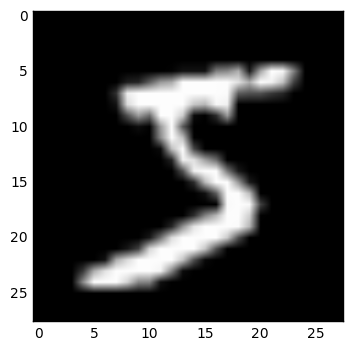

In [4]:
# Plotting example image
img = mnist.train.images[0]
img_resize = img.reshape((img_size, img_size))
plt.imshow(img_resize, cmap = 'gray')
plt.show()

In [5]:
# Initialize weights and bias 
def weight_variable(shape):
    return tf.Variable(xavier_initializer(shape))

def bias_variable(shape):
	return tf.Variable(xavier_initializer(shape))

# Xavier Weights initializer
def xavier_initializer(shape):
	dim_sum = np.sum(shape)
	if len(shape) == 1:
		dim_sum += 1
	bound = np.sqrt(2.0 / dim_sum)
	return tf.random_uniform(shape, minval=-bound, maxval=bound)

## Multi LSTM RNN Network

In [6]:
# Network

# Reset the graph
tf.reset_default_graph()

# Input 
x_image  = tf.placeholder(tf.float32, shape = [None, img_flat_size])
y_target = tf.placeholder(tf.float32, shape=[None, num_label])
keep_prob = tf.placeholder(tf.float32)


input_flat = tf.reshape(x_image,[-1, step_size , flatten_size])

# Making Multi L
layers = []
for layer in range(num_lstm_layers):
    # LSTM cell
    lstm = tf.contrib.rnn.BasicLSTMCell(num_units=lstm_size)
    # Add Dropout to the cell
    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob = keep_prob)
    layers.append(drop)
    
MultiLSTMcell = tf.contrib.rnn.MultiRNNCell(layers)

# Get lstm cell output
rnn_out, rnn_state = tf.nn.dynamic_rnn(MultiLSTMcell, input_flat, dtype = tf.float32)
    
# Vectorization
rnn_out = rnn_out[:, -1, :]
rnn_out = tf.reshape(rnn_out ,shape = [-1, lstm_size])

# Densely connect layer variables 
w_fc1 = weight_variable([lstm_size, 256])
b_fc1 = bias_variable([256])

w_fc2 = weight_variable([256, num_label])
b_fc2 = bias_variable([num_label])

# Fully Connected Layer
h_fc1 = tf.nn.relu(tf.matmul(rnn_out, w_fc1)+b_fc1)
output = tf.matmul(h_fc1, w_fc2)+b_fc2

# Training 
Loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = y_target, logits = output)
Cost = tf.reduce_mean(Loss)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, epsilon = epsilon).minimize(Cost)

correct_prediction = tf.equal(tf.argmax(y_target,1), tf.argmax(output,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Making Dataset

In [7]:
# Dataset for train, test, validation

test_len = mnist.test.images.shape[0]
validation_len = int(test_len * validation_ratio)

train_x = mnist.train.images
test_x = mnist.test.images[validation_len : test_len, :]
validation_x = mnist.test.images[ : validation_len, :]

train_y = mnist.train.labels
test_y = mnist.test.labels[validation_len : test_len]
validation_y = mnist.test.labels[ : validation_len]

print("Training set: " + str(train_x.shape))
print("Testing set: " + str(test_x.shape))
print("Validation set: " + str(validation_x.shape))

Training set: (60000, 784)
Testing set: (9000, 784)
Validation set: (1000, 784)


## Create Session

In [8]:
# Create Session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = gpu_fraction

sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())

data = np.insert(train_x, img_flat_size, train_y, axis = 1)
len_data = data.shape[0]

## Training

In [9]:
# Training
for i in range(num_epoch):
    np.random.shuffle(data)

    data_x = data[:, :img_flat_size]
    data_y = data[:, img_flat_size]

    data_y_onehot = np.zeros([data_y.shape[0], num_label])
    for j in range(data_y.shape[0]):
        data_y_onehot[j, int(data_y[j])] = 1
    
    data_y_onehot_val = np.zeros([validation_y.shape[0], num_label])
    for j in range(validation_y.shape[0]):
        data_y_onehot_val[j, int(validation_y[j])] = 1
        
    batch_count = 1
    for j in range(0, len_data, batch_size):
        if j + batch_size < len_data:
            data_x_in = data_x[j : j + batch_size, :]
            data_y_in = data_y_onehot[j : j + batch_size, :]
        else:
            data_x_in = data_x[j : len_data, :]
            data_y_in = data_y_onehot[j : len_data, :]

        optimizer.run(feed_dict = {x_image: data_x_in, y_target: data_y_in, keep_prob: keep_prob_dropout})
        cost = sess.run(Cost, feed_dict = {x_image: data_x_in, y_target: data_y_in, keep_prob: keep_prob_dropout})
        acc = sess.run(accuracy, feed_dict = {x_image: data_x_in, y_target: data_y_in, keep_prob: keep_prob_dropout})
        val_acc = sess.run(accuracy, feed_dict = {x_image: validation_x, y_target: data_y_onehot_val, keep_prob: keep_prob_dropout})
        
        print("Epoch: " + str(i+1) + ' / ' + "Batch: " + str(j) + '/' + str(len_data) + ' / ' + "Cost: " + str(cost) + ' / ' + \
              "Training Accuracy: " + str(acc) + ' / ' + "Validation Accuracy: " + str(val_acc))

    

Epoch: 1 / Batch: 0/60000 / Cost: 0.694359 / Training Accuracy: 0.109375 / Validation Accuracy: 0.087
Epoch: 1 / Batch: 512/60000 / Cost: 0.656809 / Training Accuracy: 0.125 / Validation Accuracy: 0.127
Epoch: 1 / Batch: 1024/60000 / Cost: 0.563057 / Training Accuracy: 0.0800781 / Validation Accuracy: 0.107
Epoch: 1 / Batch: 1536/60000 / Cost: 0.426524 / Training Accuracy: 0.101563 / Validation Accuracy: 0.095
Epoch: 1 / Batch: 2048/60000 / Cost: 0.354402 / Training Accuracy: 0.0839844 / Validation Accuracy: 0.093
Epoch: 1 / Batch: 2560/60000 / Cost: 0.333004 / Training Accuracy: 0.125 / Validation Accuracy: 0.095
Epoch: 1 / Batch: 3072/60000 / Cost: 0.337942 / Training Accuracy: 0.0917969 / Validation Accuracy: 0.098
Epoch: 1 / Batch: 3584/60000 / Cost: 0.341026 / Training Accuracy: 0.0976563 / Validation Accuracy: 0.093
Epoch: 1 / Batch: 4096/60000 / Cost: 0.342711 / Training Accuracy: 0.0996094 / Validation Accuracy: 0.084
Epoch: 1 / Batch: 4608/60000 / Cost: 0.336351 / Training Acc

## Testing

In [10]:
# Testing

test_y_onehot = np.zeros([test_y.shape[0], num_label])
for i in range(test_y.shape[0]):
    test_y_onehot[i, int(test_y[i])] = 1

test_result = sess.run(output, feed_dict = {x_image: test_x, keep_prob: 1})

count_correct = 0
for i in range(test_result.shape[0]):
    prediction_y = np.argmax(test_result[i,:])
    
    if prediction_y == test_y[i]:
        count_correct += 1

test_acc = count_correct / test_result.shape[0]

print("Test Accuracy: " + str(test_acc))

Test Accuracy: 0.9622222222222222
